In [38]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [39]:
import warnings
warnings.filterwarnings('ignore', 'The behavior of `series.*`', FutureWarning)
warnings.filterwarnings('ignore', 'invalid value encountered', RuntimeWarning)


In [40]:
# model.save('1-v4-model.h5')
# model.save_weights('1-v4-weights.h5')
# # model.load_weights('v4-weights.h5')
# # model.load_model('v4-model.h5')
# # Evaluate the model
# train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)
# print("Train Loss:", train_loss)
# print("Test Loss:", test_loss)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import yfinance as yf
from datetime import datetime

In [42]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.version.VERSION

/device:GPU:0
Num GPUs Available:  1


'2.10.0'

In [43]:
import ta

In [44]:
# Load the Bitcoin price data
bitcoin_data = pd.read_csv(r'C:\Users\MrBios\Documents\Development\test\csv\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
bitcoin_data.dropna(inplace=True)
bitcoin_data = bitcoin_data.tail(20000)
bitcoin_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4837326,1615945800,56300.39,56336.34,56286.07,56301.89,0.123955,6981.853240,56325.890606
4837327,1615945860,56300.35,56363.04,56300.35,56315.49,2.947734,166099.944940,56348.346387
4837328,1615945920,56313.62,56335.71,56251.14,56251.14,0.256604,14450.328612,56313.757265
4837329,1615945980,56189.74,56189.74,56161.85,56172.91,1.046248,58779.246895,56180.971891
4837330,1615946040,56202.03,56208.33,56171.76,56171.76,0.089151,5010.668818,56204.253967
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [45]:
# bitcoin_data = add_all_ta_features(bitcoin_data,
#                                            open="Open",
#                                            high="High",
#                                            low="Low",
#                                            close="Close",
#                                            volume="Volume_(Currency)",
#                                            fillna=True)
# add RSI, MACD, MACD signal, MACD histogram
# bitcoin_data['RSI'] = ta.momentum.rsi(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD'] = ta.trend.macd(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_signal'] = ta.trend.macd_signal(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_diff'] = ta.trend.macd_diff(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['SMA_20'] = ta.trend.sma_indicator(close=bitcoin_data["Close"], fillna=True)

In [46]:
# Prepare the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data[["Close"]])
# save scaler
np.save('scalerv5.npy', scaler)

# add more features to scaled data
# scaled_data = scaler.fit_transform(bitcoin_data[["Close", "Volume_(BTC)", "Volume_(Currency)", "RSI", "MACD", "MACD_signal", "MACD_diff", "SMA_20"]])


In [47]:
# Create sequences of data with a given time step
time_step = 200  # Number of previous time steps to consider for predicting the next time step
X = []
y = []
for i in range(time_step, len(scaled_data) - 30):
    X.append(scaled_data[i - time_step:i, 0])
    y.append(scaled_data[i:i + 30, 0])
X = np.array(X)
y = np.array(y)

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Reshape X to match the expected input shape of the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [50]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=30))

In [51]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [52]:
import tensorflow as tf

# Set TensorFlow to only allocate memory on the GPU when needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [53]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
248/248 [==============================] - ETA: 0s - loss: 0.0328

: 

: 

In [ ]:
now = datetime.now()
format_date = now.strftime("%Y-%m-%d-%H-%M")
model.save(f'models/1-v4-model_{format_date}.h5')
model.save_weights(f'models/1-v4-weights_{format_date}.h5')
# model.load_weights('v4-weights.h5')
# model.load_model('v4-model.h5')

In [ ]:
# Make predictions
predictions = model.predict(X_test)


125/125 [==============================] - 1s 4ms/step


In [ ]:
# Scale the predictions back to original values
predictions = scaler.inverse_transform(predictions)
# Scale the predictions back to original values
# Reshape the predictions to match the expected shape of (1982, 30)

In [ ]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 56197.1229368837


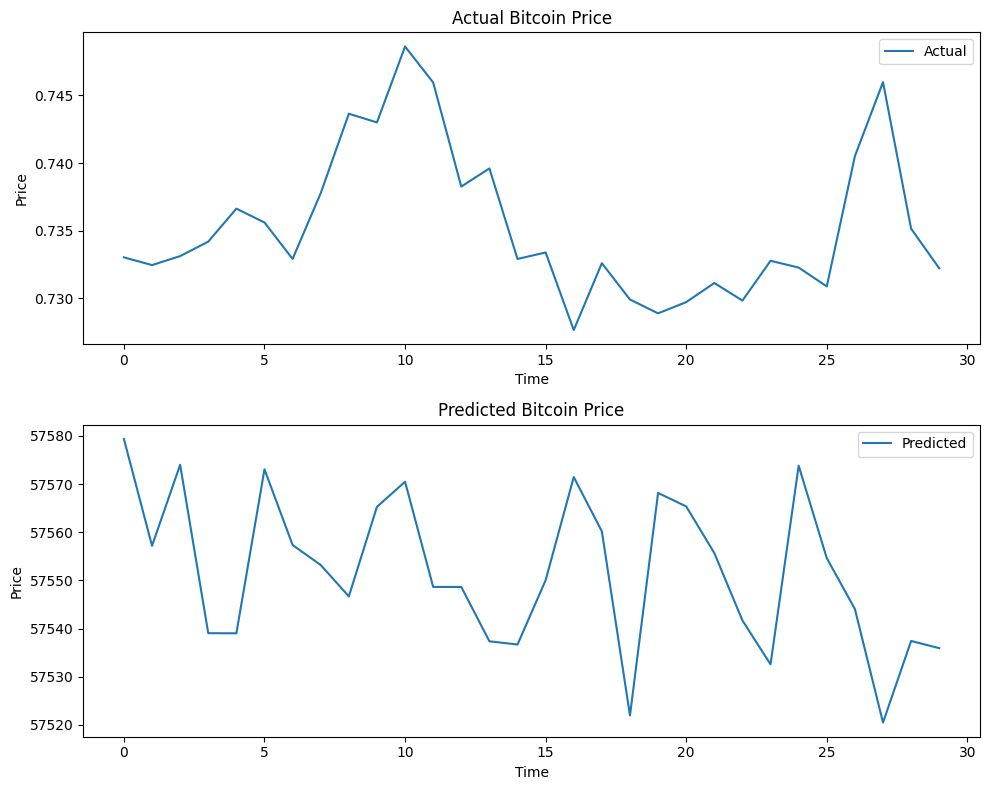

In [ ]:
# Create two separate subplots for actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the actual values
ax1.plot(y_test[0], label='Actual')
ax1.set_title('Actual Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot the predicted values
ax2.plot(predictions[0], label='Predicted')
ax2.set_title('Predicted Bitcoin Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Format the tick labels to display numbers in regular format
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
bitcoin_data.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857366,1617148200,58673.20,58689.44,58673.20,58689.44,0.576412,33822.378068,58677.435702
4857367,1617148260,58677.05,58699.90,58660.00,58699.90,2.672676,156832.692130,58680.021260
4857369,1617148380,58718.68,58731.23,58698.34,58698.50,0.207983,12209.055282,58702.294657
4857370,1617148440,58736.19,58762.43,58736.19,58739.95,0.041559,2441.376572,58745.145351
4857371,1617148500,58742.18,58742.18,58714.31,58714.31,2.519999,148004.448110,58731.946927
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [ ]:
# timestamp to datetime
bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'], unit='s')
bitcoin_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4837326,2021-03-17 01:50:00,56300.39,56336.34,56286.07,56301.89,0.123955,6981.853240,56325.890606
4837327,2021-03-17 01:51:00,56300.35,56363.04,56300.35,56315.49,2.947734,166099.944940,56348.346387
4837328,2021-03-17 01:52:00,56313.62,56335.71,56251.14,56251.14,0.256604,14450.328612,56313.757265
4837329,2021-03-17 01:53:00,56189.74,56189.74,56161.85,56172.91,1.046248,58779.246895,56180.971891
4837330,2021-03-17 01:54:00,56202.03,56208.33,56171.76,56171.76,0.089151,5010.668818,56204.253967
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [ ]:
import yfinance as yf
from datetime import datetime
import numpy as np

In [ ]:
# downloade the data with yfinance, get the last 2 hours
last_60_minutes = yf.download(tickers='BTC-USD', period='5d', interval='1h')
# print last data
last_60_minutes.tail(1)


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-06-17 23:00:00+00:00,26565.511719,26569.099609,26539.271484,26539.271484,26539.271484,3237888


In [ ]:

# 2. Scale the data to be values between 0 and 1
last_60_minutes_scaled = scaler.fit_transform(last_60_minutes[["Close"]])
# 3. Reshape the data into the shape accepted by the LSTM model
last_60_minutes_scaled = np.reshape(last_60_minutes_scaled, (1, last_60_minutes_scaled.shape[0], 1)) # cannot reshape array of size 60 into shape (1,1,1)
# 4. Make predictions using the LSTM model
pred = model.predict(last_60_minutes_scaled)
pred = scaler.inverse_transform(pred)

1/1 [==============================] - 1s 514ms/step


array([[26474.016, 26470.812, 26474.023, 26467.248, 26466.953, 26473.166,
        26471.412, 26467.709, 26467.775, 26470.55 , 26473.598, 26468.129,
        26467.768, 26466.883, 26464.56 , 26468.566, 26471.518, 26468.602,
        26459.525, 26470.602, 26472.074, 26467.021, 26465.86 , 26462.39 ,
        26475.846, 26468.582, 26467.426, 26458.432, 26464.158, 26462.602]],
      dtype=float32)

In [ ]:
# 5. Print the predicted price
print("The Bitcoin price will move from {} to {} in the next 30 minutes.".format(last_60_minutes["Close"].iloc[-1], pred[0][-1]))

The Bitcoin price will move from 26539.271484375 to 26462.6015625 in the next 30 minutes.


In [ ]:
# 4. Make predictions using the LSTM model
pred = model.predict(last_60_minutes_scaled)
pred = scaler.inverse_transform(pred)

1/1 [==============================] - 0s 20ms/step


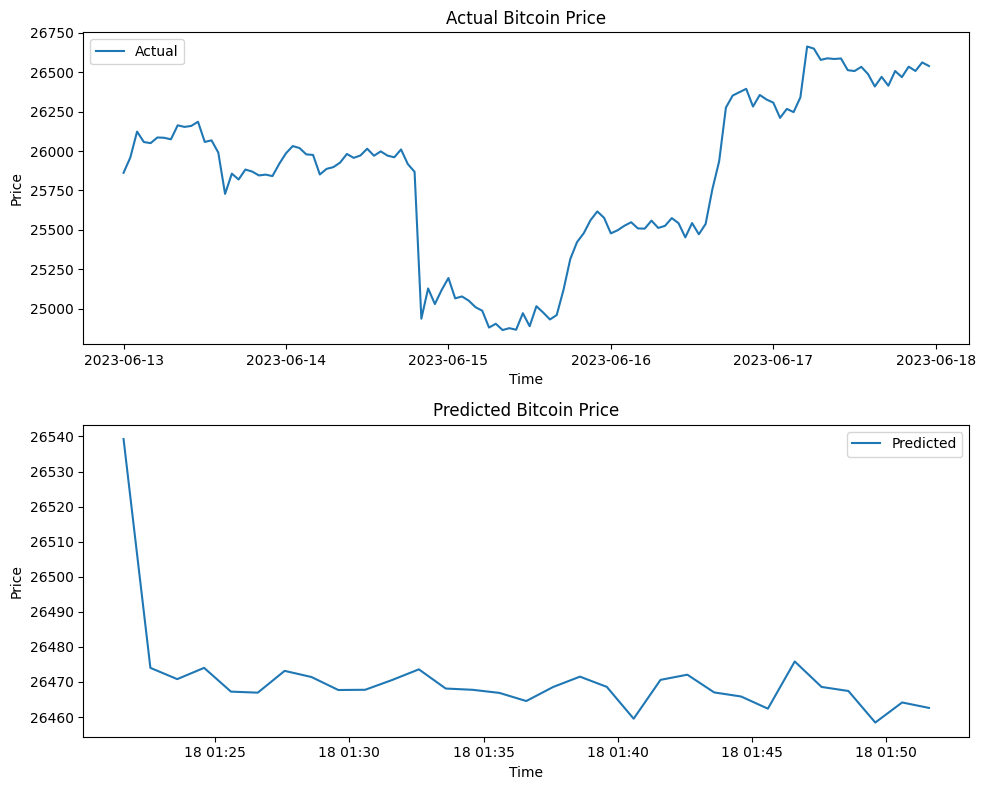

In [ ]:
# Create two separate subplots for actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the actual values
ax1.plot(last_60_minutes.index, last_60_minutes["Close"], label='Actual')
ax1.set_title('Actual Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot the predicted values
pred_time = pd.date_range(start=now, periods=31, freq='1min')
pred_values = np.concatenate(([last_60_minutes["Close"].iloc[-1]], pred[0][:30]))
ax2.plot(pred_time, pred_values, label='Predicted')
ax2.set_title('Predicted Bitcoin Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Format the tick labels to display numbers in regular format
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

# Display the plot
plt.tight_layout()
plt.show()

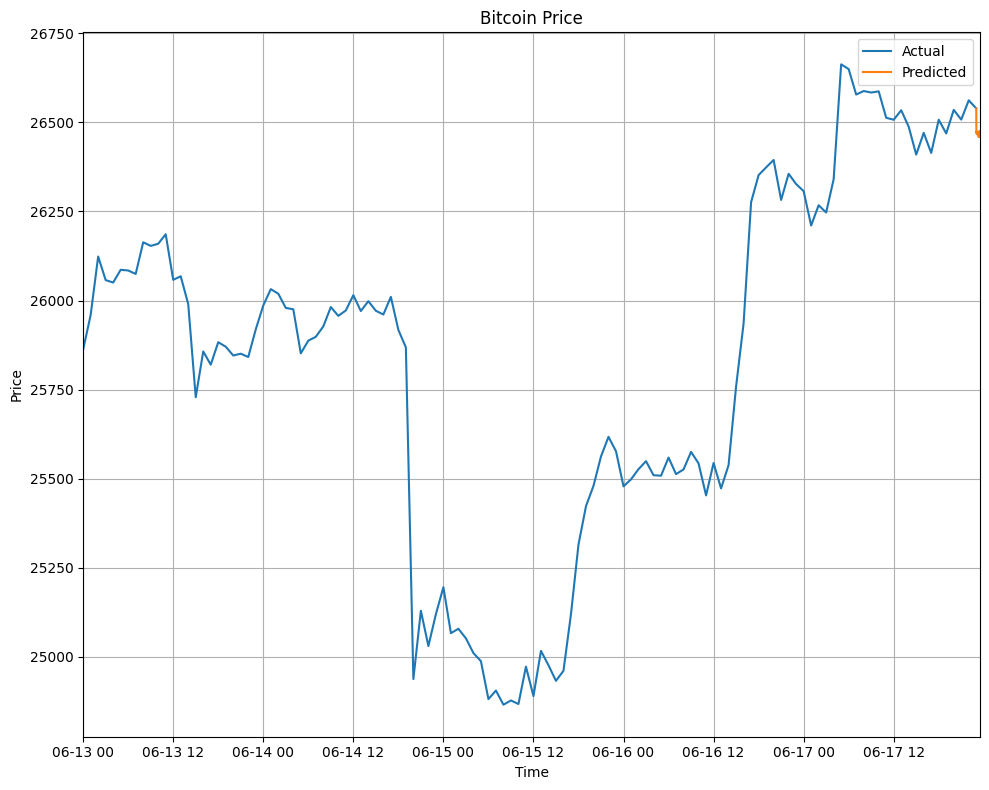

In [ ]:
# Create a single subplot for both actual and predicted values
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the actual values
ax.plot(last_60_minutes.index, last_60_minutes["Close"], label='Actual')
ax.grid(True)
ax.set_title('Bitcoin Price')
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Plot the predicted values
pred_time = pd.date_range(start=last_60_minutes.index[-1], periods=31, freq='1min')
pred_values = np.concatenate(([last_60_minutes["Close"].iloc[-1]], pred[0][:30]))
ax.plot(pred_time, pred_values, label='Predicted')

# Format the tick labels to display numbers in regular format
ax.get_yaxis().get_major_formatter().set_useOffset(False)

# Set the x-axis limits to show both actual and predicted values
ax.set_xlim(last_60_minutes.index[0], pred_time[-1])

# Display the legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()